In [1]:
%matplotlib inline  
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_color_codes("bright")
import glob
from pylab import rcParams

pd.set_option('max_columns', 60)
pd.set_option('max_rows', 100)


In [2]:
data = pd.read_csv("H01-H12_dataTable_ONT.csv",sep=",", header=0,names=["template_ID","match","template","strandC","strandR","time","read"])
data["time"] = pd.to_datetime(data["time"])


In [3]:
# start is defined as the time stamp of the first read

data["hr_from_start"] = (data["time"].subtract(min(data["time"])))/np.timedelta64(1, 'h')
data["min_from_start"] = (data["time"].subtract(min(data["time"])))/np.timedelta64(1, 'm')
data["sec_from_start"] = (data["time"].subtract(min(data["time"])))/np.timedelta64(1, 's')
data.fillna('',inplace=True)

In [4]:
def findpossiblehits(row):
    curr_seq = row['strandC']
    desired_seq = row['template']
    
    # filter rule - look for strands of a set length and the desired terminal 'C'
    if((len(curr_seq) == len(desired_seq)) and len(curr_seq)>0 and (curr_seq[-1] is desired_seq[-1])):
        return 1
    else:
        return 0


In [5]:
data["possiblehit"] = data.apply(findpossiblehits,axis=1)

In [6]:
strands = [data.loc[data["template_ID"]=="H01"].shape[0],
           data.loc[data["template_ID"]=="H02"].shape[0],
           data.loc[data["template_ID"]=="H03"].shape[0],
           data.loc[data["template_ID"]=="H04"].shape[0],
           data.loc[data["template_ID"]=="H05"].shape[0],
           data.loc[data["template_ID"]=="H06"].shape[0],
           data.loc[data["template_ID"]=="H07"].shape[0],
           data.loc[data["template_ID"]=="H08"].shape[0],
           data.loc[data["template_ID"]=="H09"].shape[0],
           data.loc[data["template_ID"]=="H10"].shape[0],
           data.loc[data["template_ID"]=="H11"].shape[0],
           data.loc[data["template_ID"]=="H12"].shape[0]]
print(strands)

[679, 1210, 726, 1000, 1335, 581, 1360, 1519, 1580, 1647, 1375, 692]


In [7]:
# set the number of strands per template to be 500
minsample=500

H01 = data.loc[data["template_ID"]=="H01"]
H02 = data.loc[data["template_ID"]=="H02"]
H03 = data.loc[data["template_ID"]=="H03"]
H04 = data.loc[data["template_ID"]=="H04"]
H05 = data.loc[data["template_ID"]=="H05"]
H06 = data.loc[data["template_ID"]=="H06"]
H07 = data.loc[data["template_ID"]=="H07"]
H08 = data.loc[data["template_ID"]=="H08"]
H09 = data.loc[data["template_ID"]=="H09"]
H10 = data.loc[data["template_ID"]=="H10"]
H11 = data.loc[data["template_ID"]=="H11"]
H12 = data.loc[data["template_ID"]=="H12"]

data_downsampled=pd.concat([H01.sample(n=minsample),H02.sample(n=minsample),H03.sample(n=minsample),H04.sample(n=minsample),H05.sample(n=minsample),
          H06.sample(n=minsample),H07.sample(n=minsample),H08.sample(n=minsample),H09.sample(n=minsample),H10.sample(n=minsample),
          H11.sample(n=minsample),H12.sample(n=minsample)],ignore_index=True)



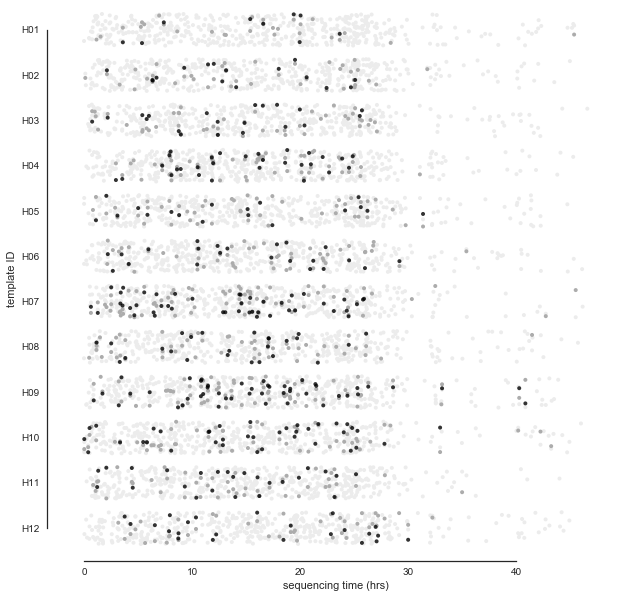

In [8]:
plt.rcParams['figure.figsize'] = 10,10
sns.set(style="white")

colorscheme = ["#ececec"]
g=sns.stripplot(data = data_downsampled, x="hr_from_start",y="template_ID", alpha = 1,palette = colorscheme,jitter = 0.35,size=4)

data_possibles = data_downsampled.loc[data_downsampled["possiblehit"]==1]
colorscheme = ["#acacac"]
g=sns.stripplot(data = data_possibles, x="hr_from_start",y="template_ID", alpha = 1, palette = colorscheme,jitter = 0.35,size=4)

data_hitsonly = data_downsampled.loc[data_downsampled["match"]==1]
colorscheme = ["black"]
g= sns.stripplot(data = data_hitsonly, x="hr_from_start",y="template_ID", alpha = 0.8,palette = colorscheme, jitter = 0.35,size=4)
g.set(ylabel='template ID')
g.set(xlabel='sequencing time (hrs)')
sns.despine(offset=10,trim=True)



In [9]:
def decodingprobs(df,hrs,num_iterations):
    df_prob_by_hrs = []
    for timepts in hrs:
        num_matches = []
        for i in range(num_iterations):
            mini = df.sample(n=df.loc[df["hr_from_start"]<=timepts].shape[0])
            mini_onlypossibles = mini
            mini_summary = mini_onlypossibles[["strandC","match","possiblehit"]].groupby(['strandC'], as_index=False).agg(['sum']).reset_index()

            newcols = [''.join(t) for t in mini_summary]
            mini_summary.columns = newcols
            mini_summary.reset_index(level=0, inplace=True)

            all_max = mini_summary["possiblehitsum"].max()
            onlymax = mini_summary[mini_summary["possiblehitsum"]==all_max]

            if((onlymax.shape[0] == 1) and (onlymax.iloc[0]["matchsum"])>0):
                num_matches.append(1)
            else:
                num_matches.append(0)
        df_prob_by_hrs.append(sum(num_matches)/num_iterations)
    return df_prob_by_hrs


In [10]:
hrs = list(range(0,50,2))
hrs.pop(0)
print(hrs[1:])

[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48]


In [11]:
iters = 50
# iters = 10000 #trials used in publication - long run time! may want to parallelize

H01_decoding = decodingprobs(H01,hrs[1:],iters)
H02_decoding = decodingprobs(H02,hrs[1:],iters)
H03_decoding = decodingprobs(H03,hrs[1:],iters)
H04_decoding = decodingprobs(H04,hrs[1:],iters)
H05_decoding = decodingprobs(H05,hrs[1:],iters)
H06_decoding = decodingprobs(H06,hrs[1:],iters)
H07_decoding = decodingprobs(H07,hrs[1:],iters)
H08_decoding = decodingprobs(H08,hrs[1:],iters)
H09_decoding = decodingprobs(H09,hrs[1:],iters)
H10_decoding = decodingprobs(H10,hrs[1:],iters)
H11_decoding = decodingprobs(H11,hrs[1:],iters)
H12_decoding = decodingprobs(H12,hrs[1:],iters)


In [12]:
pd.DataFrame(list(zip(hrs, H01_decoding, H02_decoding, H03_decoding, H04_decoding,
                     H05_decoding, H06_decoding, H07_decoding, H08_decoding,
                     H09_decoding, H10_decoding, H11_decoding, H12_decoding,)),
              columns=['time (hrs)','H01','H02', 'H03','H04','H05','H06', 'H07','H08',
                      'H09','H10', 'H11','H12'])


,time (hrs),H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12
0,2,0.40,0.92,0.78,0.94,0.94,0.68,1.0,0.98,1.0,0.98,1.0,0.86
1,4,0.60,1.00,0.82,1.00,0.96,0.90,1.0,0.98,1.0,1.00,1.0,0.96
2,6,0.84,1.00,0.98,1.00,1.00,0.92,1.0,1.00,1.0,1.00,1.0,0.98
3,8,0.78,1.00,1.00,1.00,1.00,0.96,1.0,1.00,1.0,1.00,1.0,1.00
4,10,0.84,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.0,1.00,1.0,1.00
5,12,0.88,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.0,1.00,1.0,1.00
6,14,0.90,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.0,1.00,1.0,1.00
7,16,0.94,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.0,1.00,1.0,1.00
8,18,0.96,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.0,1.00,1.0,1.00
9,20,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.0,1.00,1.0,1.00


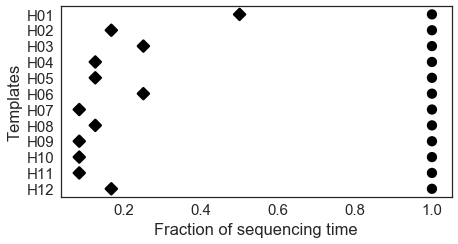

In [13]:
# plot the data for previously calculated results 
# Set 48 hours as 1.0 of sequencing time

sns.set(font_scale=1.5)
sns.set_style("white")


strand_decoding = {'H01':[24,48],'H02':[8,48],'H03':[12,48],'H04':[6,48],'H05':[6,48],'H06':[12,48],
                   'H07':[4,48],'H08':[6,48],'H09':[4,48],'H10':[4,48],'H11':[4,48],'H12':[8,48]}

strand_decoding_df = pd.DataFrame.from_dict(strand_decoding)
strand_decoding_df = strand_decoding_df/48
strand_decoding_df["method"] = pd.Series(['ONT','MiSeq'])
strand_decoding_df_melted = pd.DataFrame.melt(strand_decoding_df,id_vars='method')


fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(7,3.5))
strand_decoding_df_melted_ONT = strand_decoding_df_melted.loc[strand_decoding_df_melted["method"]=='ONT']
strand_decoding_df_melted_MiSeq = strand_decoding_df_melted.loc[strand_decoding_df_melted["method"]=='MiSeq']

g = sns.pointplot(x="value",y='variable',data =strand_decoding_df_melted_ONT,markers=['D'],color="black",ax=ax,join=False,scale = 1)
g = sns.pointplot(x="value",y='variable',data =strand_decoding_df_melted_MiSeq,markers=['o'],color="black",ax=ax,join=False,scale = 1)

g.set(xlabel='Fraction of sequencing time')
g.set(ylabel='Templates')


plt.savefig("decodingtimes.pdf")
